In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="kYVqzmHEUN7WQLo86k2bZs1Z7",
                        project_name="mri-epilepsy-classification", workspace="kondratevakate")
import os
import glob
import nibabel as nib
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import functools
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

/gpfs/data/opt/python-3.6.8/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/kondratevakate/mri-epilepsy-classification/bdc92c1bdac44342a1ba76b8fc96b897



In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
import sys
sys.path.append("..")

# import utils 
from utils.viz_tools import plot_central_cuts
from utils.data import MriSegmentation, MriClassification
# from utils import routine

### 0. Dataset

In [4]:
all_data = MriClassification(sample='all', data_type = 'img', ignore_missing=True,
                                  coord_min=(35,35,35), img_shape=(180,180,180))

print("Dataset size: {}".format(len(all_data)))
print("Labels distribution: {}\n".format(np.unique(all_data.target, return_counts=True)))

  0%|          | 0/1404 [00:00<?, ?it/s]

Assembling data for:  all  sample.


100%|██████████| 1404/1404 [01:31<00:00, 15.37it/s]

Dataset size: 1389
Labels distribution: (array([0, 1]), array([796, 593]))



In [20]:
soloviev_data = MriClassification(sample='soloviev', data_type = 'img', ignore_missing=True,
                                  coord_min=(35,35,35), img_shape=(180,180,180))

  1%|          | 2/181 [00:00<00:11, 16.01it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:11<00:00, 16.11it/s]


In [21]:
soloviev_data.scan_keys

array(['1.5T_soloviev'], dtype=object)

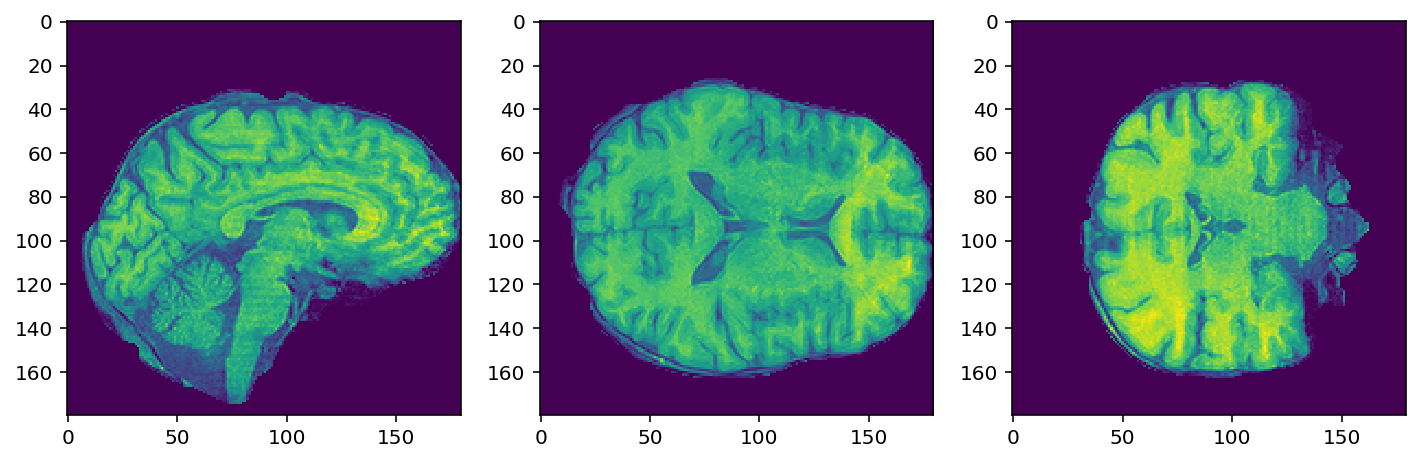

In [22]:
img, target, scan = soloviev_data[0]
plot_central_cuts(img)

In [8]:
soloviev_data.target.value_counts()

1    91
0    90
Name: fcd, dtype: int64

### 1. Classification w/o data normalisation

#### 1.1 Data 

Dataset size: 180
Labels distribution: (array([0, 1]), array([90, 90]))

Example:
Image shape: torch.Size([1, 180, 180, 180])
Target: 1


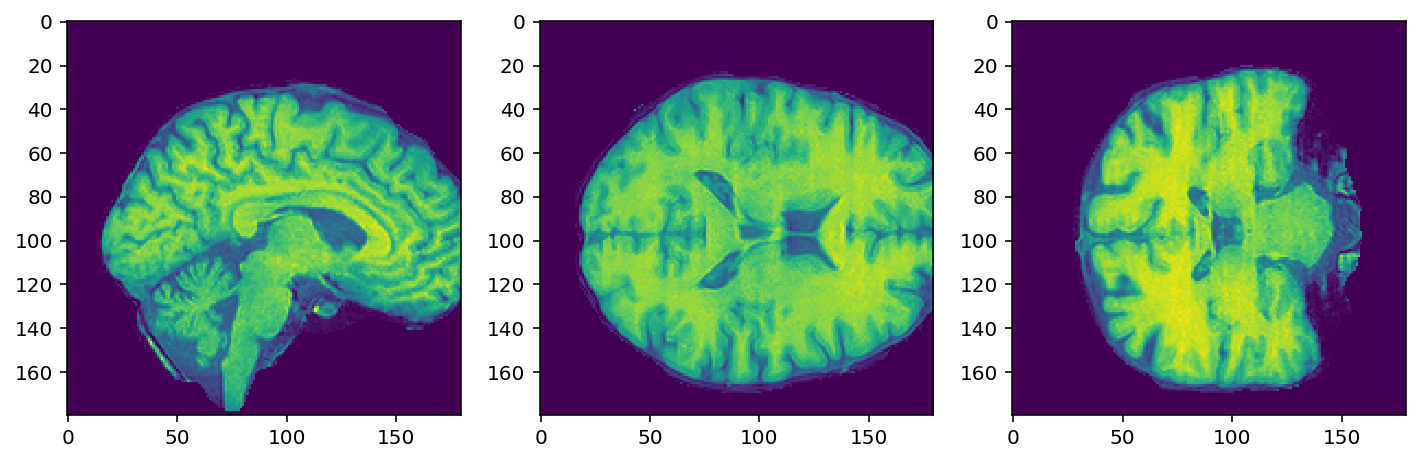

In [16]:
print("Dataset size: {}".format(len(soloviev_data)))
print("Labels distribution: {}\n".format(np.unique(soloviev_data.target, return_counts=True)))

print("Example:")
img, target, scan = soloviev_data[1]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
plot_central_cuts(img)

#### 1.2. Model and Optimiser

In [23]:
from models.cnn_model import VoxResNet, CNN

model_res = VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape= (192,192,192), dropout=0.5, n_fc_units= 192)

model_cnn = CNN(n_filters=16, stride=1, n_blocks=3, input_shape= (192,192,192), n_fc_units=192)

def create_model_opt(model, model_load_path=None, input_shape = (192,192,192), n_fc_units = 192, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=1e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    return model, opt

### 2. Training (no data normalization, full `img` dataset)

Epoch 10 of 10 took 62.723s
  training loss (in-iteration): 	0.015263
  validation loss: 			0.756675
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.36


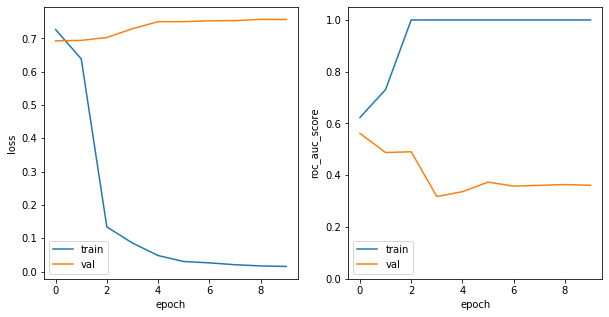

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.6257309941520468, 0.7901234567901234, 0.6141975308641975, 0.7407407407407407, 0.5617283950617284]
val roc_auc_score mean: 0.6665042235217674
val roc_auc_score std: 0.08505197926227934
CPU times: user 49min 14s, sys: 33min 48s, total: 1h 23min 3s
Wall time: 46min 32s


In [11]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, soloviev_data, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

### 3. Training  on data `seg`:

In [13]:
soloviev_data_seg = MriClassification(sample='soloviev', data_type = 'seg', ignore_missing=True,
                         image_path= '/gpfs/gpfs0/sbi/data/fcd_classification_bank',
                         targets_path= '../targets/targets_fcd_bank.csv')

  1%|          | 1/181 [00:00<00:22,  7.88it/s]

Assembling data for:  soloviev  sample.


100%|██████████| 181/181 [00:14<00:00, 12.09it/s]


Dataset size: 181
Labels distribution: (array([0, 1]), array([90, 90]))

Example:
Image shape: torch.Size([1, 192, 192, 192])
Target: 1


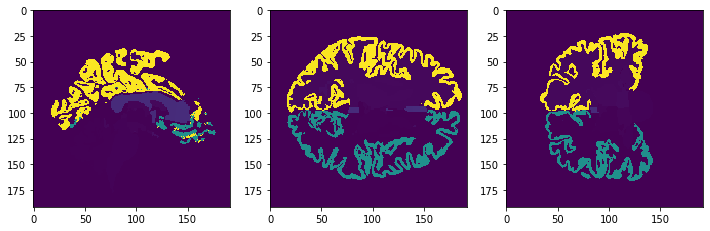

In [18]:
print("Dataset size: {}".format(len(soloviev_data_seg)))
print("Labels distribution: {}\n".format(np.unique(soloviev_data_seg.target, return_counts=True)))

print("Example:")
img, target, scan = soloviev_data_seg[1]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
plot_central_cuts(img)

Epoch 10 of 10 took 126.772s
  training loss (in-iteration): 	0.011007
  validation loss: 			0.701038
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.52


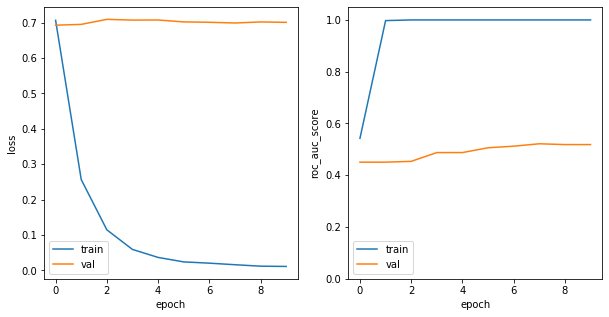

<Figure size 720x360 with 0 Axes>

val roc_auc_scores: [0.6234567901234567, 0.4598765432098766, 0.6018518518518517, 0.6049382716049383, 0.5216049382716049]
val roc_auc_score mean: 0.5623456790123457
val roc_auc_score std: 0.06207924981123268
CPU times: user 1h 41min 18s, sys: 54min 25s, total: 2h 35min 44s
Wall time: 1h 32min 37s


In [19]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, soloviev_data_seg, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

### 2. Classification with CNN dataset
#### 2.1 Adding scheduler

In [9]:
from models.cnn_model import VoxResNet, CNN

model_res = VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4,
                             input_shape= (192,192,192), dropout=0.5, n_fc_units= 192)

model_cnn = CNN(n_filters=16, stride=1, n_blocks=4, input_shape= (192,192,192), n_fc_units=192)

def create_model_opt(model, model_load_path=None, input_shape = (192,192,192), n_fc_units = 192, transfer=False):
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    if model_load_path is not None:
        model.load_state_dict(torch.load(model_load_path))  
    if transfer:
        for param in model.parameters():
            param.requires_grad = False
        
        last = torch.nn.Linear(128, 2)
        modules = list(list(model.children())[0].children())[:-1] + [last]
        model = torch.nn.Sequential(torch.nn.Sequential(*modules))
        
        opt = torch.optim.Adam(last.parameters(), lr=1e-5)
    else:
        opt = torch.optim.Adam(model.parameters(), lr=1e-5)
    return model, opt

In [10]:
import time
from comet_ml import Experiment

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from scipy import stats
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm


def run_one_epoch(model, loader, criterion, train, device, optimizer=None):
    
    model.to(device)
    model.train(train)

    losses = []
    probs = []
    targets = []

    for data, target, _ in tqdm(loader):
        data = data.to(device, dtype=torch.float)
        target = target.long().to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        if train and optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
        probs.extend(F.softmax(outputs, dim=-1).cpu().data.numpy()[:, 1])
        targets.extend(list(target.cpu().data.numpy()))
        del data, target, outputs, loss

    return losses, probs, targets


def train(model, optimizer, train_dataloader, val_dataloader, device,
          metric, verbose=0, model_save_path=None, max_epoch=10, 
          eps=3e-3, max_patience=10, experiment = False):
    
    criterion = nn.CrossEntropyLoss()

    patience = 0
    best_metric = 0

    epoch_train_loss, last_train_loss, epoch_train_metric, last_train_metric, = [], None, [], None
    epoch_val_loss, last_val_loss, epoch_val_metric, last_val_metric, = [], None, [], None

    for epoch in range(max_epoch):
        start_time = time.time()

        # 1. Train
        train_losses, train_probs, train_targets = run_one_epoch(model, train_dataloader, criterion, True, device, optimizer)

        # 2. Inference
        if val_dataloader is not None:
            with torch.no_grad():
                val_losses, val_probs, val_targets = run_one_epoch(model, val_dataloader, criterion, False, device)

        # 3. Metrics
        epoch_train_loss.append(np.mean(train_losses))
        epoch_train_metric.append(metric(train_targets, train_probs))
        if experiment:
            experiment.log_metric("train_loss", loss.data.cpu().numpy())
            experiment.log_metric("train_auc", probs.data.cpu().numpy())
        if val_dataloader is not None:
            epoch_val_loss.append(np.mean(val_losses))
            epoch_val_metric.append(metric(val_targets, val_probs))
            if experiment:
                experiment.log_metric("val_loss", loss.data.cpu().numpy())
                experiment.log_metric("val_auc", probs.data.cpu().numpy())

        # 4. Print metrics
        if verbose:
            clear_output(True)
            print("Epoch {} of {} took {:.3f}s".format(epoch + 1, max_epoch, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(epoch_train_loss[-1]))
            if val_dataloader is not None:
                print("  validation loss: \t\t\t{:.6f}".format(epoch_val_loss[-1]))
            print("  training {}: \t\t\t{:.2f}".format(metric.__name__, epoch_train_metric[-1]))
            if val_dataloader is not None:
                print("  validation {}: \t\t\t{:.2f}".format(metric.__name__, epoch_val_metric[-1]))    
            
        # 5. Plot metrics
        if verbose:
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            plt.figure(figsize=(10, 5))
            axes[0].plot(epoch_train_loss, label='train')
            if val_dataloader is not None:
                axes[0].plot(epoch_val_loss, label='val')
            axes[0].set_xlabel('epoch')
            axes[0].set_ylabel('loss')
            axes[0].legend()
            axes[1].plot(epoch_train_metric, label='train')
            if val_dataloader is not None:
                axes[1].plot(epoch_val_metric, label='val')
            axes[1].set_ylim([0, 1.05])
            axes[1].set_xlabel('epoch')
            axes[1].set_ylabel(metric.__name__)
            axes[1].legend()
            plt.show()
        
        # 5. Early stopping, best metrics, save model
#         if val_dataloader is not None and epoch_val_metric[-1] > best_metric:
#             patience = 0
#             best_metric = epoch_val_metric[-1]
#             last_train_metric, last_val_metric = epoch_train_metric[-1], epoch_val_metric[-1]
#             last_train_loss, last_val_loss = epoch_train_loss[-1], epoch_val_loss[-1]
#             if model_save_path is not None:
#                     torch.save(model.state_dict(), model_save_path)
                    
#         elif val_dataloader is None and epoch_train_metric[-1] >= best_metric:
#             patience = 0
#             best_metric = epoch_train_metric[-1]
#             last_train_metric = epoch_train_metric[-1]
#             last_train_loss = epoch_train_loss[-1]
#             if model_save_path is not None:
#                 torch.save(model.state_dict(), model_save_path)
#         else:
#             patience += 1

#         if patience >= max_patience:
#             print("Early stopping! Patience is out.")
#             break
#         if epoch_train_loss[-1] < eps:
#             print("Early stopping! Train loss < eps.")
#             break

        last_train_metric = epoch_train_metric[-1]
        last_train_loss = epoch_train_loss[-1]
    
        if experiment:
            experiment.log_epoch_end(epoch)
        if model_save_path is not None:
                torch.save(model.state_dict(), model_save_path)

    return last_train_loss, last_train_metric, last_val_loss, last_val_metric


def stratified_batch_indices(indices, labels):
    dominating_label = stats.mode(labels)[0][0]
    idx0 = indices[labels == dominating_label]
    idx1 = indices[labels != dominating_label]
    step = np.ceil(len(idx0) / len(idx1)) + 1
    assert step >= 1.
    result = []
    j0 = 0
    j1 = 0
    for i in range(len(indices)):
        if (i % step == 0 or j0 == len(idx0)) and j1 < len(idx1):
            result.append(idx1[j1])
            j1 += 1
        else:
            result.append(idx0[j0])
            j0 += 1
    result = np.array(result)
    assert len(result) == len(indices)
    return result


In [11]:
experiment.set_name("Baseline classification, Vox-CNN")

In [19]:
def cross_val_score(model, optimizer, train_dataset, cv, device, metric,  model_load_path=None,
        batch_size=10, val_dataset=None, transfer=False, finetune=False, experiment = False):
    
    assert not (transfer and finetune)
    assert (transfer == False) or (transfer == True and model_load_path is not None)

    use_rest = True
    if val_dataset is None:  # smri case or fmri case without rest
        val_dataset = train_dataset
        use_rest = False

    cv_splits = list(cv.split(X=np.arange(len(train_dataset)), y=train_dataset.target))
    val_metrics = []

    for i in range(len(cv_splits)):
        train_idx, val_idx = cv_splits[i]

        # train data
        if model_load_path is None or transfer or finetune:
            train_idx = stratified_batch_indices(train_idx, train_dataset.target[train_idx])
            train_loader = DataLoader(Subset(train_dataset, train_idx),
                                      shuffle=False,
                                      batch_size=batch_size,
                                      drop_last=False)

        # val data
        if use_rest:
            val_mask = (np.isin(val_dataset.pids, train_dataset.pids[train_idx]) == False)
            val_idx = np.arange(len(val_dataset))[val_mask]
            del val_mask
        
        val_loader = DataLoader(Subset(val_dataset, val_idx),
                                shuffle=False,
                                batch_size=batch_size,
                                drop_last=False)

        eps = 1e-2 if use_rest else 3e-3
        _, _, _, last_val_metric = train(model, optimizer, train_loader, val_loader, device,
                                             metric=metric, verbose=1, eps=eps, experiment=False)
        val_metrics.append(last_val_metric)
        
        
        if model_load_path:  # no train, just validation
            model, optimizer = create_model_opt(model_load_path, transfer=False)
            criterion = nn.CrossEntropyLoss()
            with torch.no_grad():
                val_losses, val_probs, val_targets = run_one_epoch(model, val_loader, criterion, False, device)
            val_metric = metric(val_targets, val_probs)
            val_metrics.append(val_metric)
            
        del train_loader, val_loader, model, optimizer

    return val_metrics

In [28]:
%%time

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model, optimizer = create_model_opt(model_cnn)
metric = roc_auc_score
val_metrics = cross_val_score(model, optimizer,
                                      train_dataset = soloviev_data,
                                      cv= cv,
                                      device = device, 
                                      metric = roc_auc_score, 
                                      batch_size = 5,
                                      experiment = experiment)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

  0%|          | 0/29 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.11 GiB (GPU 0; 10.92 GiB total capacity; 2.67 GiB already allocated; 1.18 GiB free; 4.66 GiB reserved in total by PyTorch)

In [26]:

# model, opt = create_model_opt(model_cnn)